# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

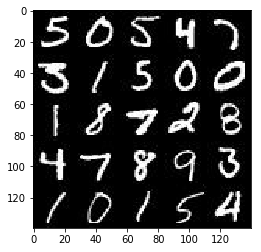

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

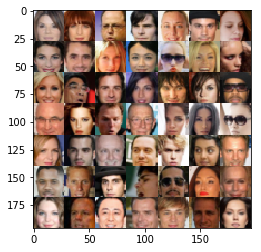

In [4]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), 
                                       name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [90]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """ 
    with tf.variable_scope('discriminator', reuse=reuse):            
        # Input layer is 28x28xd
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print("x1: ",x1.shape[1:])
        # output is 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print("x2: ", x2.shape[1:])
        # output is 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=1, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # output is 4x4x256       
            
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [89]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # first fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Re-shape for conv stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print("x1: ",x1.shape)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print("x2: ",x2.shape)
        # 7x7x256 now     
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print("x3: ",x3.shape)
        # 14x14x2128 now
        
    
        # output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        #print("logits: ",logits.shape)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


#### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                        labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
class GAN():
    def __init__(self, im_w, im_h, im_channels, z_dim, alpha=0.2, beta1=0.5):
        self.alpha, self.beta1 = alpha, beta1
        self.input_real, self.input_z, self.learning_rate = model_inputs(im_w, im_h, im_channels, z_dim)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, im_channels, alpha=self.alpha)
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, self.beta1)

In [96]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    net = GAN(data_shape[1], data_shape[2], data_shape[3], z_dim, alpha=0.2, beta1=beta1)
    
    num_batches = 0
    print_every_n = 10
    show_every_n = 200
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                num_batches += 1
                batch_images = batch_images * 2 # re-scale due to [-0.5,-0.5] range on input images
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, 
                                                   net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z,
                                                 net.learning_rate: learning_rate})
                
                if num_batches % print_every_n == 0:
                    
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if num_batches % show_every_n == 0:
                    show_generator_output(sess, 25, net.input_z, data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6613... Generator Loss: 0.3955
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 0.9510
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 0.6547
Epoch 1/2... Discriminator Loss: 0.8059... Generator Loss: 1.1850
Epoch 1/2... Discriminator Loss: 1.1423... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 2.1668... Generator Loss: 0.2362
Epoch 1/2... Discriminator Loss: 0.7381... Generator Loss: 2.3180
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 1.1439
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.6347


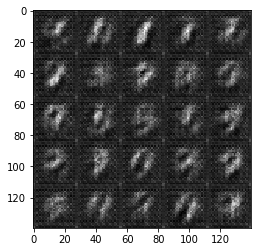

Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 1.4558
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.5127
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.9664
Epoch 1/2... Discriminator Loss: 1.1045... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.8194
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 1.0754
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 1.0328
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 1.3017


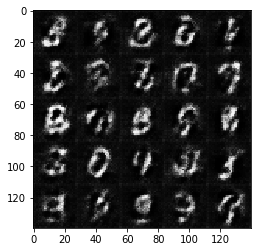

Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 1.5542
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 1.6902
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 1.6227
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 1.8971
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 1.9455
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 1.5487
Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 1.6630
Epoch 1/2... Discriminator Loss: 0.8265... Generator Loss: 1.2248
Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 0.9640
Epoch 1/2... Discriminator Loss: 0.7097... Generator Loss: 1.5547


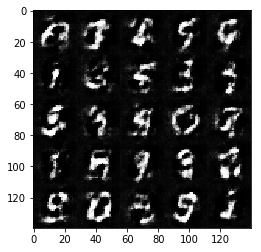

Epoch 1/2... Discriminator Loss: 1.5726... Generator Loss: 0.2835
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 1.2861
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 0.7393... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 0.6988... Generator Loss: 1.0032
Epoch 1/2... Discriminator Loss: 0.8202... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 1.4414
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.7592


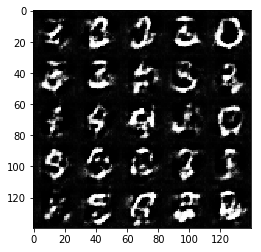

Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 1.0909
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.0420
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 1.0278
Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.3689
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 2.3363
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.4269
Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 0.8216... Generator Loss: 1.1925
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.4144


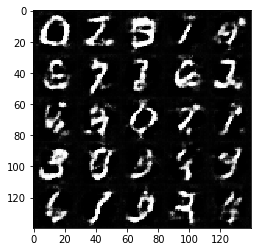

Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.4046
Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 1.8562
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 0.6201
Epoch 1/2... Discriminator Loss: 0.7897... Generator Loss: 1.8443
Epoch 1/2... Discriminator Loss: 0.7740... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.3505
Epoch 1/2... Discriminator Loss: 0.7034... Generator Loss: 1.0561


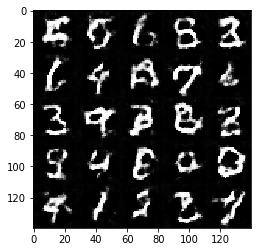

Epoch 1/2... Discriminator Loss: 0.6635... Generator Loss: 1.9535
Epoch 1/2... Discriminator Loss: 1.0087... Generator Loss: 0.6003
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 2.0757
Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 1.0391
Epoch 1/2... Discriminator Loss: 0.7356... Generator Loss: 0.9837
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.2177
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 1.1072
Epoch 1/2... Discriminator Loss: 0.9404... Generator Loss: 0.7092
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 0.6083


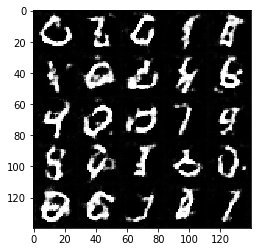

Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 0.7913... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 0.6694... Generator Loss: 1.1294
Epoch 1/2... Discriminator Loss: 0.8334... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 0.8059... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 0.6258... Generator Loss: 1.4280
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 1.3971
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.5394


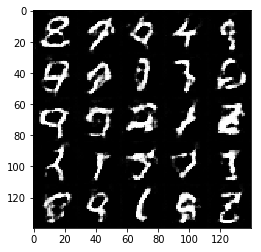

Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 0.7469... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 0.5218
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 0.4760
Epoch 1/2... Discriminator Loss: 0.6308... Generator Loss: 1.4188
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 0.8489
Epoch 1/2... Discriminator Loss: 0.6709... Generator Loss: 1.0828
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 2.8735... Generator Loss: 4.1427
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.0267


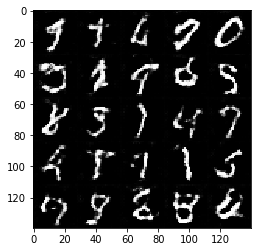

Epoch 1/2... Discriminator Loss: 0.9567... Generator Loss: 0.6885
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 0.5422
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 1.1525
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.2243
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 1.0841... Generator Loss: 0.5414
Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 0.9022
Epoch 2/2... Discriminator Loss: 4.3538... Generator Loss: 5.0772


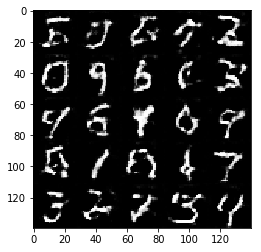

Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 1.5422
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 0.8232... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.4484
Epoch 2/2... Discriminator Loss: 0.7437... Generator Loss: 0.9292
Epoch 2/2... Discriminator Loss: 0.8922... Generator Loss: 2.3500
Epoch 2/2... Discriminator Loss: 0.5719... Generator Loss: 1.1556
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 0.7170


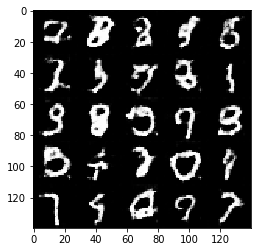

Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 0.6845
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 0.5597... Generator Loss: 1.2063
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.5298
Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 0.8959
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 0.8625
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.0963
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 1.1215


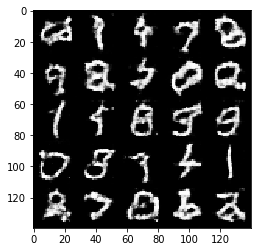

Epoch 2/2... Discriminator Loss: 0.8144... Generator Loss: 0.9787
Epoch 2/2... Discriminator Loss: 0.6422... Generator Loss: 1.1691
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 0.9403
Epoch 2/2... Discriminator Loss: 0.6009... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 0.6938... Generator Loss: 1.0783
Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 1.7083... Generator Loss: 0.2732
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 0.6855
Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 0.9267
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 0.7174


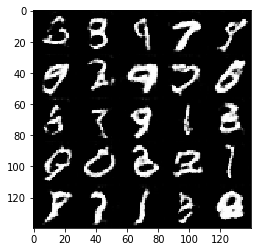

Epoch 2/2... Discriminator Loss: 2.5617... Generator Loss: 0.1235
Epoch 2/2... Discriminator Loss: 0.9057... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 0.7941... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 0.5670... Generator Loss: 1.3972
Epoch 2/2... Discriminator Loss: 1.2119... Generator Loss: 2.9290
Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 1.9546
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.2027
Epoch 2/2... Discriminator Loss: 0.4806... Generator Loss: 1.9997
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 0.9801


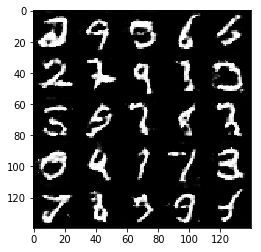

Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 0.7162... Generator Loss: 1.1912
Epoch 2/2... Discriminator Loss: 0.6283... Generator Loss: 1.0159
Epoch 2/2... Discriminator Loss: 0.5568... Generator Loss: 1.3721
Epoch 2/2... Discriminator Loss: 0.5370... Generator Loss: 1.8390
Epoch 2/2... Discriminator Loss: 0.6045... Generator Loss: 1.2939
Epoch 2/2... Discriminator Loss: 0.6466... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 0.4830... Generator Loss: 1.4368
Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 1.8301
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 0.7688


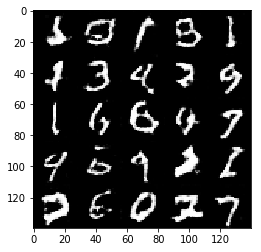

Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 0.4275
Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 0.8521
Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 1.2431
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 1.0777
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 0.9574
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 0.6425
Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 1.4393
Epoch 2/2... Discriminator Loss: 0.5504... Generator Loss: 1.5552
Epoch 2/2... Discriminator Loss: 2.1080... Generator Loss: 0.2288


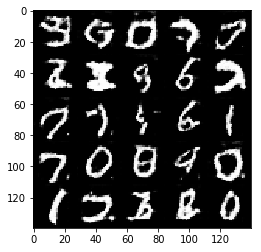

Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 0.5390... Generator Loss: 1.5739
Epoch 2/2... Discriminator Loss: 0.8799... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 0.5008... Generator Loss: 1.4660
Epoch 2/2... Discriminator Loss: 0.6547... Generator Loss: 1.2242
Epoch 2/2... Discriminator Loss: 0.5987... Generator Loss: 1.1139
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 0.9870
Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 1.6915


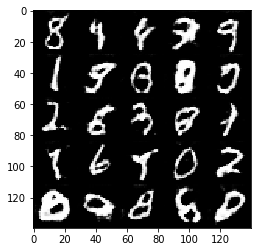

Epoch 2/2... Discriminator Loss: 2.8206... Generator Loss: 4.8698
Epoch 2/2... Discriminator Loss: 1.5551... Generator Loss: 0.3553
Epoch 2/2... Discriminator Loss: 0.7291... Generator Loss: 1.3049
Epoch 2/2... Discriminator Loss: 0.6277... Generator Loss: 1.2442
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 1.3891
Epoch 2/2... Discriminator Loss: 0.5905... Generator Loss: 1.6494
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 0.4786... Generator Loss: 1.8959


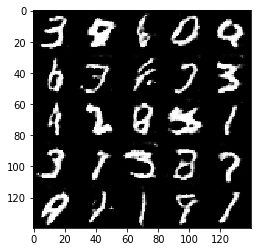

Epoch 2/2... Discriminator Loss: 0.6670... Generator Loss: 1.0031
Epoch 2/2... Discriminator Loss: 0.4488... Generator Loss: 2.0844
Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 1.3090
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.5633
Epoch 2/2... Discriminator Loss: 0.4606... Generator Loss: 1.3534
Epoch 2/2... Discriminator Loss: 0.5898... Generator Loss: 1.7499


In [93]:
batch_size = 64
z_dim = 70
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.8806... Generator Loss: 0.0354
Epoch 1/1... Discriminator Loss: 1.6284... Generator Loss: 0.4434
Epoch 1/1... Discriminator Loss: 1.7856... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 2.3644
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 0.2937... Generator Loss: 4.6452
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 1.4882
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 3.8576
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 1.5072
Epoch 1/1.

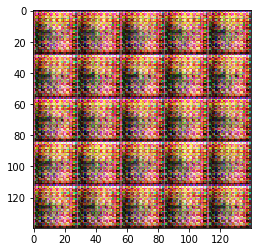

Epoch 1/1... Discriminator Loss: 0.1805... Generator Loss: 2.1541
Epoch 1/1... Discriminator Loss: 0.1543... Generator Loss: 2.4728
Epoch 1/1... Discriminator Loss: 0.2006... Generator Loss: 2.8586
Epoch 1/1... Discriminator Loss: 0.2228... Generator Loss: 2.1025
Epoch 1/1... Discriminator Loss: 0.2385... Generator Loss: 2.3055
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 1.6303
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 2.2928
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.6238
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.1854
Epoch 1/1.

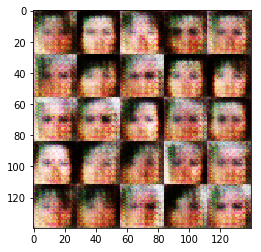

Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 2.0067
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.6270
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 2.0856
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.6912
Epoch 1/1.

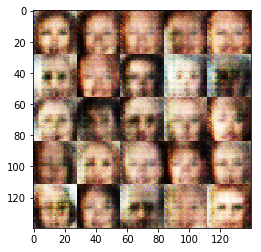

Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.6393
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.4460
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.8224
Epoch 1/1.

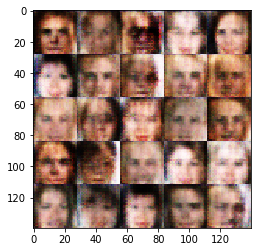

Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.4751
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.3820
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.1552
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.6821
Epoch 1/1.

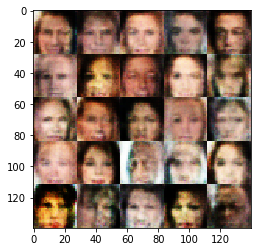

Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.6085
Epoch 1/1.

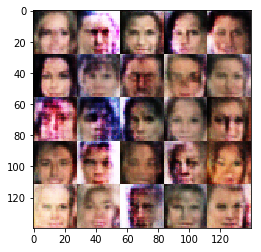

Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.6495
Epoch 1/1.

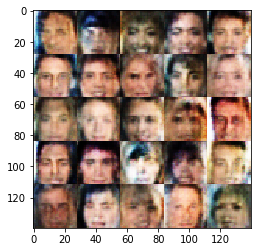

Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.5649
Epoch 1/1.

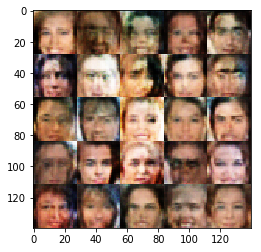

Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.3777
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.8801
Epoch 1/1.

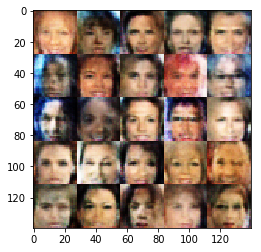

Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.5701
Epoch 1/1.

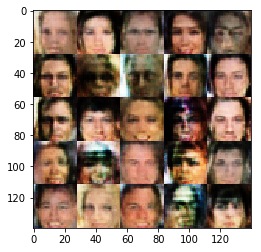

Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.8777
Epoch 1/1.

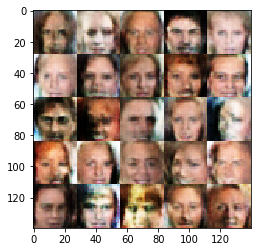

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 0.2808
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.6533... Generator Loss: 0.3009
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.7893
Epoch 1/1.

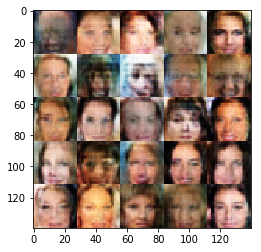

Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.7306... Generator Loss: 0.2727
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.3092
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 0.8480
Epoch 1/1.

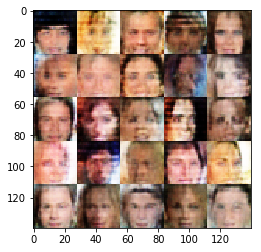

Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.3296
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.5416
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.4662
Epoch 1/1.

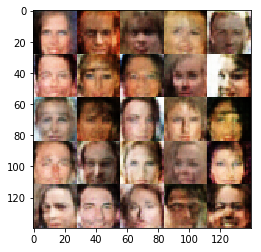

Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.7758... Generator Loss: 0.2466
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.3871
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.7030
Epoch 1/1.

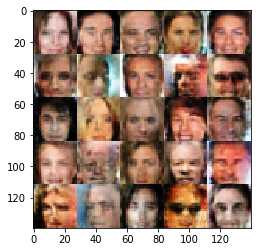

Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.3324
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.3647
Epoch 1/1.

In [98]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.